# Comparing IMAU FDM output to ice and firn core output

## Find the closest FDM points to ice cores from QGreenland and firn cores collected in sumup

In [31]:
from scipy.spatial.distance import cdist
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy.spatial import cKDTree
from datetime import datetime,timedelta

In [2]:
# import FDM locations

path_to_fdm_locations = "/perm/nld4814/code/IMAU-FDM/reference/FGRN055/"
df_fdm = pd.read_csv(path_to_fdm_locations+'IN_ll_FGRN055.txt',names=["longitude","latitude"],usecols=[0,1])

# import ice core locations from QGreenland

path_to_qgreenland = "/perm/nld4814/cores/qgreenland/"
df_geojson = gpd.read_file(path_to_qgreenland+"ice_cores.geojson")

df_qg = pd.DataFrame(columns=['name','latitude','longitude'])

for idx in range(0,len(df_geojson)):
    #find lat
    idx_start_lat = df_geojson.iloc[idx].description.find("LATITUDE") + 10
    idx_end = df_geojson.iloc[idx].description[idx_start_lat:idx_start_lat+20].find("<")
    idx_end_lat = idx_start_lat+idx_end
    lat = df_geojson.iloc[idx].description[idx_start_lat:idx_end_lat]
    
    #find lon
    idx_start_lon = df_geojson.iloc[idx].description.find("LONGITUDE") + 11
    idx_end = df_geojson.iloc[idx].description[idx_start_lon:idx_start_lon+20].find("<")
    idx_end_lon = idx_start_lon+idx_end
    lon = df_geojson.iloc[idx].description[idx_start_lon:idx_end_lon]


    new_row = {'name': df_geojson.iloc[idx].Name, 'latitude': lat, 'longitude': lon}

    # Append the new row using loc
    df_qg.loc[len(df_qg)] = new_row
    
    #print(idx,lat,lon)

df_qg = df_qg.drop_duplicates()
df_qg = df_qg.reset_index()

# import sumup locations

path_to_SUMup_folder = '/perm/nld4814/cores/sumup/'
df_sumup_density = xr.open_dataset(
    path_to_SUMup_folder+'data/SUMup_2024_density_greenland.nc',
    group='DATA').to_dataframe()

ds_meta = xr.open_dataset(
    path_to_SUMup_folder + 'data/SUMup_2024_density_greenland.nc',
    group='METADATA')

# more elegant decoding
for v in ['profile','reference','reference_short','method']:
    ds_meta[v] = ds_meta[v].str.decode('utf-8')

# ds_meta contain the meaning of profile_key, reference_key, method_key being
# used in df_density

# % creating a metadata frame
# that contains, for each unique location, the important information
# (lat/lon, reference...)
df_sumup_meta = df_sumup_density[
    ['profile_key','latitude','longitude','timestamp','reference_key','method_key']
    ].drop_duplicates()

df_sumup_meta['name'] = ds_meta.profile.sel(profile_key= df_sumup_meta.profile_key.values)
df_sumup_meta['method'] = ds_meta.method.sel(method_key= df_sumup_meta.method_key.values)
df_sumup_meta['reference'] = ds_meta.reference.sel(reference_key= df_sumup_meta.reference_key.values)
df_sumup_meta['reference_short'] = ds_meta.reference_short.sel(reference_key= df_sumup_meta.reference_key.values)
df_sumup_meta = df_sumup_meta.set_index('profile_key')



In [13]:
def nearest_latlon_profile(df, points, return_value=True):
    # inspired from https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/Nearest_lat-lon_Grid.ipynb

    if 'lat' in df: df = df.rename(dict(lat='latitude', lon='longitude'))
    if isinstance(points, tuple): points = [points]

    xs = []; distances = []  # distance between the pair of points

    for point in points:
        assert len(point) == 2, "``points`` should be a tuple or list of tuples (lat, lon)"

        p_lat, p_lon = point
        # Find absolute difference between requested point and the grid coordinates.
        abslat = np.abs(df.latitude - p_lat)
        abslon = np.abs(df.longitude - p_lon)

        # Create grid of the maximum values of the two absolute grids
        c = np.maximum(abslon, abslat)

        # Find location where lat/lon minimum absolute value intersects
        x = np.where(c == np.min(c))[0][0]
        xs.append(x)

        # Matched Grid lat/lon
        g_lat = df.iloc[x,:].latitude
        g_lon = df.iloc[x,:].longitude

        R = 6373.0  # approximate radius of earth in km

        lat1 = np.deg2rad(p_lat); lon1 = np.deg2rad(p_lon)
        lat2 = np.deg2rad(g_lat); lon2 = np.deg2rad(g_lon)
        dlon = lon2 - lon1; dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        distance = R * c
        distances.append(distance)
        print(point, 'closest to profile',x,' (%0.4f°N, %0.4f°E) %0.4f km away'%(
            g_lat, g_lon, R * c))
    return df.iloc[xs,:].index

In [17]:
coord_list=[(df_fdm.iloc[36618].latitude,df_fdm.iloc[36618].longitude)]
ind_list = nearest_latlon_profile(df_sumup_meta, coord_list)

(75.6459, -36.0909) closest to profile 1594  (75.6300°N, -36.0000°E) 3.0687 km away


In [28]:
df_sumup_meta.iloc[1594]

latitude                                                   75.630005
longitude                                                      -36.0
timestamp                                        2016-06-01 00:00:00
reference_key                                                  254.0
method_key                                                       4.0
name                                              EastGRIP Main Core
method                                      ice or firn core section
reference          Rasmussen, Sune Olander; Vinther, Bo Møllesøe;...
reference_short                              Rasmussen et al. (2023)
Name: 2864.0, dtype: object

In [33]:
# find closest lat/lon in fdm to cores in qgreenland and sumup

fdm_coords = df_fdm[["latitude", "longitude"]].to_numpy()
qg_coords = df_qg[["latitude", "longitude"]].to_numpy()
sumup_coords = df_sumup_meta[["latitude", "longitude"]].to_numpy()

tree = cKDTree(fdm_coords)

distances1, indices1 = tree.query(qg_coords)
distances2, indices2 = tree.query(sumup_coords)

# Add the index of the closest match from df1 into df2
df_qg["fdm_index"] = indices1
df_qg["distance"] = distances1  # (optional) distance to the closest point
df_qg = df_qg[df_qg["distance"]<1]
df_qg["dataset"] = "qgreenland"

df_sumup_meta["fdm_index"] = indices2
df_sumup_meta["distance"] = distances2  # (optional) distance to the closest point
df_sumup_meta = df_sumup_meta[df_sumup_meta["distance"]<1]
df_sumup_meta["dataset"] = "sumup"

df_fdm_points = df_qg[["fdm_index","distance","name"]]
df_fdm_points=df_fdm_points._append(df_sumup_meta[["fdm_index","distance","name","timestamp"]],ignore_index=True)
df_fdm_points_merge = df_fdm_points.groupby("fdm_index",as_index=False).agg({"name": ", ".join})

In [126]:
#output to text

df_fdm_points_merge["fdm_index"].to_csv("/perm/nld4814/code/IMAU-FDM/rundir/pointlists/pointlist_cores.txt",header=False,index=False)

## Compare FDM output and firn/ice core density, FAC, temperature, etc

In [156]:
# East GRIP 

#from sumup
profile_key = df_sumup_meta[df_sumup_meta["name"]=="EastGRIP Main Core"].index
df_sumup_meta[df_sumup_meta["name"]=="EastGRIP Main Core"]
df_eastgrip = df_sumup_density.loc[df_sumup_density["profile_key"]==2864.0]




Text(0.5, 1.0, 'EastGRIP (fdm:36618)')

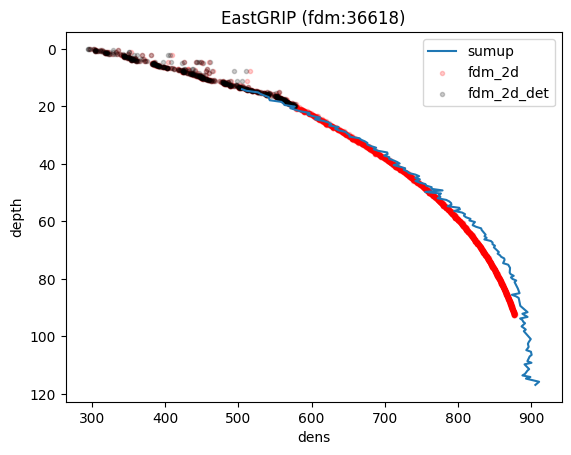

In [193]:
ax = df_eastgrip.plot(x='density',y='midpoint',title='EastGRIP (fdm:36618)')
fdm_2D.sel(ind_t=1025).plot.scatter(x='dens',y='depth',marker='.',color='red',ax=ax,alpha=0.2)
fdm_2D_detail.sel(ind_t=3079).plot.scatter(x='dens',y='depth',marker='.',color='k',alpha=0.2,ax=ax)

ax.invert_yaxis()
plt.legend(["sumup","fdm_2d","fdm_2d_det"])

plt.title('EastGRIP (fdm:36618)')

In [ ]:
# 1. for each point in the sumup dataset, get the closest fdm number
# 2. for each point in the sumup dataset, get the density (plot vs. 2d)
# 3. for each point in the sumup dataset, get the temperature (plot vs 2d)
# 4. for each point in the sumup dataset, get the smb (plot vs 1d)
# 5. add a place holder for date so we can plot the correct date for the fdm



In [64]:
# post-processing fdm data by point, adapted from Sanne's scripts

from datetime import datetime,timedelta

domain = "FGRN055"
var = "dens"

start_date = datetime(1939,9,1)
end_date = datetime(2023,12,31)
nyears = end_date.year - start_date.year	# amount of years 1940-2023, not including last part of 1939 (1939.66575)
ndays_timestep = 10      # in days, of shortest write time (usually 1 or 10 days, set in start_model_ccab in sec)

fdm_index = 36618
run_name = "cores"
dir_model_output = "/ec/res4/scratch/nld4814/"+run_name+"/output/"
dir_mask = "/perm/nld4814/code/IMAU-FDM/reference/" + domain + "/"

#Import 1D, 2D, and 2Ddetail data
fdm_1D = xr.open_dataset(dir_model_output+"FGRN055_era055_1D_"+str(fdm_index)+".nc")
fdm_2D = xr.open_dataset(dir_model_output+"FGRN055_era055_2D_"+str(fdm_index)+".nc")
fdm_2D_detail = xr.open_dataset(dir_model_output+"FGRN055_era055_2Ddetail_"+str(fdm_index)+".nc")

# create timestep dimension

def create_fdm_datetime(df, start_date, end_date, ndays_timestep):

    ##################
    
    # df: fdm data output (1d, 2d, 2ddetail)
    # start_date: start date of dataset
    # end_date: end date of dataset
    # ndays_timestep: output frequency in days (usually 1, 10, or 30 days, specified in start_model_ccab)


    # Initialize an empty list
    date_list = []
    start_date += timedelta(days=ndays_timestep)
     
    # Loop through the range of dates and append to the list
    while start_date <= end_date:
        date_list.append(start_date)
        start_date += timedelta(days=ndays_timestep)


    

# Open mask 
# fname_lsm = dir_mask + domain + "_Masks.nc"                     # Antarctica mask
# model_lsm = xr.open_dataset(fname_lsm)			# open mask
# model_IceMask = model_lsm['IceMask']			# IceMask variable
# model_Lat = model_lsm['lat']				# Latitude variable
# model_Lon = model_lsm['lon']				# Longitude variable
# n_lat = len(model_IceMask)				# Dimension length latitudes
# n_lon = len(model_IceMask[0])				# Dimension length longitudes 


#Matrix_1 = np.empty([len(date_list),n_lat,n_lon])           # Empty 3D array  
#Matrix_1[:,:,:] = np.nan			   # Fill with nan

In [82]:
fdm_1D=fdm_1D.isel(ind_t=slice(0,len(date_list)))
fdm_1D.assign_coords(time=date_list)
fdm_1D.swap_dims({"ind_t":"time"})


<xarray.Dataset> Size: 222kB
Dimensions:   (time: 3080)
Dimensions without coordinates: time
Data variables: (12/18)
    h_surf    (time) float32 12kB ...
    vice      (time) float32 12kB ...
    vacc      (time) float32 12kB ...
    vfc       (time) float32 12kB ...
    vmelt     (time) float32 12kB ...
    vbouy     (time) float32 12kB ...
    ...        ...
    refreeze  (time) float32 12kB ...
    rain      (time) float32 12kB ...
    surfmelt  (time) float32 12kB ...
    solin     (time) float32 12kB ...
    icemass   (time) float32 12kB ...
    Rho0      (time) float32 12kB ...